In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [2]:
# Cell 1: Load Local CSV Data
def load_local_data(file_path):
    """Load local CSV data"""
    try:
        df = pd.read_csv(file_path)
        print(f"Loaded {len(df)} records from {file_path}")
        return df
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None
    
file_path = 'Final_file.csv'  # Update with your actual file path
df = load_local_data(file_path)


Loaded 1000000 records from Final_file.csv


In [3]:
def remove_rows_with_empty_values(df):
    """
    Remove rows that have any empty/null values in any column.
    
    Parameters:
        df (pandas.DataFrame): The input DataFrame
        
    Returns:
        pandas.DataFrame: DataFrame with empty rows removed
    """
    # Store original row count
    original_count = len(df)
    
    # Drop rows with any NaN or empty values
    # This handles NaN, None, and empty strings
    clean_df = df.dropna(how='any')
    
    # Additional check for empty strings that might not be caught by dropna
    # Loop through string columns and remove rows with empty strings
    for col in df.select_dtypes(include=['object']).columns:
        clean_df = clean_df[clean_df[col].str.strip() != '']
    
    # Calculate and print the number of rows removed
    rows_removed = original_count - len(clean_df)
    print(f"Removed {rows_removed} rows with empty values ({rows_removed/original_count:.2%} of the data)")
    
    return clean_df
# remove_rows_with_empty_values(df)

In [4]:
def engineer_features(df):
    """
    Apply feature engineering based on requirements:
    - Temporal features
    - Geospatial features
    - Derived features
    """
    # Create a copy to avoid warnings
    data = df.copy()
    
    # Check for and drop rows with any empty/null values
    original_count = len(data)
    data = data.dropna(how='any')
    
    # Additional check for empty strings that might not be caught by dropna
    for col in data.select_dtypes(include=['object']).columns:
        data = data[data[col].str.strip() != '']
    
    # Calculate and print the number of rows removed
    rows_removed = original_count - len(data)
    print(f"Removed {rows_removed} rows with empty values ({rows_removed/original_count:.2%} of the data)")
    
    # Print the available columns to debug
    print("Available columns in the dataset:")
    print(data.columns.tolist())
    
    # Find datetime columns - look for columns that might contain pickup/dropoff time
    datetime_cols = [col for col in data.columns if 'time' in col.lower() or 'date' in col.lower()]
    print(f"Potential datetime columns: {datetime_cols}")
    
    # Get the first few rows to inspect the data
    print("\nFirst few rows of the dataset:")
    print(data.head(2))
    
    # Determine pickup and dropoff datetime columns
    pickup_col = 'tpep_pickup_datetime'  # Common name in NYC taxi datasets
    dropoff_col = 'tpep_dropoff_datetime'  # Common name in NYC taxi datasets
    
    # Check if the columns exist, otherwise try alternatives
    if pickup_col not in data.columns:
        # Try to find appropriate columns
        for col in data.columns:
            if 'pickup' in col.lower() and ('time' in col.lower() or 'date' in col.lower()):
                pickup_col = col
                break
    
    if dropoff_col not in data.columns:
        # Try to find appropriate columns
        for col in data.columns:
            if 'dropoff' in col.lower() and ('time' in col.lower() or 'date' in col.lower()):
                dropoff_col = col
                break
    
    print(f"Using {pickup_col} as pickup datetime column")
    print(f"Using {dropoff_col} as dropoff datetime column")
    
    # Sample a few date values to check format
    print(f"\nSample pickup times: {data[pickup_col].head(3).tolist()}")
    
    # Ensure datetime format for pickup and dropoff - with dayfirst=True for DD-MM-YYYY format
    try:
        # Set dayfirst=True to handle DD-MM-YYYY format
        data[pickup_col] = pd.to_datetime(data[pickup_col], dayfirst=True)
        data[dropoff_col] = pd.to_datetime(data[dropoff_col], dayfirst=True)
    except ValueError as e:
        print(f"Error parsing dates: {str(e)}")
        print("Trying with format='mixed' to handle various date formats...")
        try:
            data[pickup_col] = pd.to_datetime(data[pickup_col], format='mixed', dayfirst=True)
            data[dropoff_col] = pd.to_datetime(data[dropoff_col], format='mixed', dayfirst=True)
        except Exception as e2:
            print(f"Still having issues with date parsing: {str(e2)}")
            print("Please check your dataset and update the column names accordingly.")
            return data  # Return unmodified data to avoid breaking the pipeline
    except KeyError as e:
        print(f"Error: Column not found - {str(e)}")
        print("Please check your dataset and update the column names accordingly.")
        return data  # Return unmodified data to avoid breaking the pipeline
    
    # Add new columns with standardized names for the rest of the pipeline
    data['pickup_datetime'] = data[pickup_col]
    data['dropoff_datetime'] = data[dropoff_col]
    
    # 1. Temporal Features
    data['pickup_hour'] = data['pickup_datetime'].dt.hour

    # Define rush hours (7-10 AM, 4-7 PM)
    data['is_rush_hour'] = ((data['pickup_hour'] >= 7) & (data['pickup_hour'] <= 10)) | \
                          ((data['pickup_hour'] >= 16) & (data['pickup_hour'] <= 19))
    data['is_rush_hour'] = data['is_rush_hour'].astype(int)

    # Weekend flag
    data['is_weekend'] = (data['pickup_datetime'].dt.dayofweek >= 5).astype(int)

    # 2. Geospatial Features
    # Check for location columns
    location_cols = [col for col in data.columns if 'locat' in col.lower() or 'zone' in col.lower()]
    print(f"Potential location columns: {location_cols}")
    
    # Determine pickup location column
    pu_location_col = 'PULocationID'  # Default name
    if pu_location_col not in data.columns:
        for col in location_cols:
            if 'pu' in col.lower() or 'pickup' in col.lower():
                pu_location_col = col
                break
    
    print(f"Using {pu_location_col} as pickup location column")
    
    # Assuming airport zones are defined (modify these IDs based on actual data)
    # Check if the column exists before using it
    if pu_location_col in data.columns:
        airport_zones = [1, 132, 138]  # Example IDs for JFK and LGA zones
        data['is_airport_pickup'] = data[pu_location_col].isin(airport_zones).astype(int)
    else:
        print(f"Warning: Column {pu_location_col} not found. Setting is_airport_pickup to 0.")
        data['is_airport_pickup'] = 0

    # 3. Derived Features
    # Trip duration in seconds
    data['trip_duration'] = (data['dropoff_datetime'] - data['pickup_datetime']).dt.total_seconds()

    return data
# engineer_features(df)

In [5]:
def preprocess_data(df):
    """
    Apply preprocessing steps:
    - Remove rows with any empty values
    - Remove invalid rows based on business rules
    - Handle outliers
    - Prepare features for modeling
    """
    # Start with a copy
    data = df.copy()
    
    # Step 1: Remove rows with any empty/null values
    original_count = len(data)
    data = data.dropna(how='any')
    
    # Additional check for empty strings that might not be caught by dropna
    for col in data.select_dtypes(include=['object']).columns:
        data = data[data[col].str.strip() != '']
    
    # Calculate and print the number of rows removed due to empty values
    rows_removed_empty = original_count - len(data)
    print(f"Removed {rows_removed_empty} rows with empty values ({rows_removed_empty/original_count:.2%} of the data)")
    
    # Step 2: Remove Invalid Rows based on business rules
    invalid_count = len(data)
    
    # Drop rows with invalid trip distance or fare
    data = data[data['trip_distance'] > 0]
    data = data[data['total_amount'] >= 2.50]
    
    # Handle datetime columns
    try:
        # Ensure pickup_datetime and dropoff_datetime exist as datetime objects
        if 'pickup_datetime' not in data.columns:
            print("Warning: pickup_datetime not found, skipping time-based filtering")
        elif 'dropoff_datetime' not in data.columns:
            print("Warning: dropoff_datetime not found, skipping time-based filtering")
        else:
            # Verify these are actually datetime types
            if not pd.api.types.is_datetime64_any_dtype(data['pickup_datetime']):
                print("Converting pickup_datetime to datetime format")
                data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'], dayfirst=True, errors='coerce')
                
            if not pd.api.types.is_datetime64_any_dtype(data['dropoff_datetime']):
                print("Converting dropoff_datetime to datetime format")
                data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'], dayfirst=True, errors='coerce')
                
            # Drop rows where datetime conversion failed
            data = data.dropna(subset=['pickup_datetime', 'dropoff_datetime'])
            
            # Drop rows with negative duration (where dropoff is before pickup)
            data = data[data['dropoff_datetime'] > data['pickup_datetime']]
    except Exception as e:
        print(f"Error processing datetime columns: {str(e)}")
        print("Continuing with partial preprocessing...")
        
    # Report rows removed due to invalid data
    rows_removed_invalid = invalid_count - len(data)
    print(f"Removed {rows_removed_invalid} invalid rows based on business rules ({rows_removed_invalid/invalid_count:.2%} of filtered data)")

    # Step 3: Outlier Handling
    # Cap trip distance at 50 miles
    data['trip_distance'] = data['trip_distance'].clip(upper=50)

    # Cap total_amount at $500
    data['total_amount'] = data['total_amount'].clip(upper=500)
    
    # Check for other problematic columns like 'Temperature_C'
    if 'Temperature_C' in data.columns:
        # Drop rows with invalid temperature if present
        temp_filtered_count = len(data)
        data = data[data['Temperature_C'].notnull()]
        data = data[data['Temperature_C'] > -50]  # Filter out unreasonable temps
        data = data[data['Temperature_C'] < 60]   # Filter out unreasonable temps
        temp_rows_removed = temp_filtered_count - len(data)
        if temp_rows_removed > 0:
            print(f"Removed {temp_rows_removed} rows with invalid Temperature_C values")
    
    print(f"Final dataset size after preprocessing: {len(data)} rows")
    return data
preprocess_data(df)

Removed 81286 rows with empty values (8.13% of the data)
Removed 23240 invalid rows based on business rules (2.53% of filtered data)
Final dataset size after preprocessing: 895474 rows


,Unnamed: 0.1,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
16,16,2829,2,01-01-2024 00:04,01-01-2024 00:39,1.0,5.02,1.0,N,114,...,0.0,1.0,43.30,2.5,0.0,01-01-2024 00:04,26.772471,87.385380,4.965877,8.243974
17,17,5253,1,01-01-2024 00:05,01-01-2024 00:16,2.0,1.40,1.0,N,90,...,0.0,1.0,16.40,2.5,0.0,01-01-2024 00:04,26.772471,87.385380,4.965877,8.243974
18,18,2560,2,01-01-2024 00:05,01-01-2024 00:07,1.0,0.82,1.0,N,229,...,0.0,1.0,10.80,2.5,0.0,01-01-2024 00:04,26.772471,87.385380,4.965877,8.243974
19,19,3394,1,01-01-2024 00:05,01-01-2024 00:33,1.0,8.20,1.0,N,148,...,0.0,1.0,41.60,2.5,0.0,01-01-2024 00:04,26.772471,87.385380,4.965877,8.243974
20,20,1191,2,01-01-2024 00:05,01-01-2024 00:20,4.0,2.39,1.0,N,144,...,0.0,1.0,24.72,2.5,0.0,01-01-2024 00:04,26.772471,87.385380,4.965877,8.243974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,999994,14214623,1,11-05-2024 02:52,11-05-2024 03:02,1.0,1.10,1.0,N,107,...,0.0,1.0,18.00,2.5,0.0,11-05-2024 02:50,22.957995,45.009441,7.833538,2.801995
999995,999995,14215089,1,11-05-2024 02:52,11-05-2024 03:04,1.0,1.70,1.0,N,164,...,0.0,1.0,19.70,2.5,0.0,11-05-2024 02:50,22.957995,45.009441,7.833538,2.801995
999997,999997,14214576,1,11-05-2024 02:55,11-05-2024 03:03,1.0,1.60,1.0,N,148,...,0.0,1.0,16.70,2.5,0.0,11-05-2024 02:53,-5.946101,52.270434,2.663325,3.419218
999998,999998,14214748,1,11-05-2024 02:55,11-05-2024 02:59,4.0,1.20,1.0,N,141,...,0.0,1.0,14.60,2.5,0.0,11-05-2024 02:53,-5.946101,52.270434,2.663325,3.419218


In [6]:
# Cell 4: Data Visualization
def visualize_data(df):
    """Create visualizations to understand the data and relationships"""
    plt.figure(figsize=(16, 12))

    # Plot distribution of target variable
    plt.subplot(2, 2, 1)
    sns.histplot(df['total_amount'], bins=50, kde=True)
    plt.title('Distribution of Total Fare Amount')
    plt.xlabel('Total Amount ($)')
    plt.ylabel('Frequency')

    # Plot relationship between distance and fare
    plt.subplot(2, 2, 2)
    sns.scatterplot(data=df.sample(1000), x='trip_distance', y='total_amount')
    plt.title('Fare vs. Trip Distance')
    plt.xlabel('Trip Distance (miles)')
    plt.ylabel('Total Amount ($)')

    # Plot fare by hour of day
    plt.subplot(2, 2, 3)
    hourly_fares = df.groupby('pickup_hour')['total_amount'].mean().reset_index()
    sns.barplot(data=hourly_fares, x='pickup_hour', y='total_amount')
    plt.title('Average Fare by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Fare ($)')

    # Plot fare comparison: weekday vs weekend
    plt.subplot(2, 2, 4)
    sns.boxplot(data=df, x='is_weekend', y='total_amount')
    plt.title('Fare Comparison: Weekday vs Weekend')
    plt.xlabel('Weekend (1) vs Weekday (0)')
    plt.ylabel('Total Amount ($)')

    plt.tight_layout()
    plt.show()


In [7]:
def prepare_features(df):
    """Prepare features for modeling including weather data"""
    
    # Check which weather columns exist in the dataframe
    weather_columns = []
    potential_weather_cols = ['Temperature_C', 'Humidity_pct', 'Precipitation_mm', 'Wind_Speed_kmh']
    
    for col in potential_weather_cols:
        if col in df.columns:
            weather_columns.append(col)
    
    if weather_columns:
        print(f"Found weather columns: {weather_columns}")
    else:
        print("No weather columns found in the dataset")
    
    # Select core features
    core_features = [
        'trip_distance',         # Distance is a key factor
        'trip_duration',         # Duration helps model traffic delays
        'pickup_hour',           # Temporal feature
        'is_rush_hour',          # Temporal feature for demand patterns
        'is_weekend',            # Temporal feature for demand patterns
        'is_airport_pickup',     # Geospatial feature
    ]
    
    # Combine core features with available weather features
    features = core_features + weather_columns
    
    print(f"Using these features for modeling: {features}")
    
    # Target variable
    target = 'total_amount'
    
    # Create feature matrix and target vector
    X = df[features]
    y = df[target]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Print feature summary
    print(f"\nFeature matrix shape: {X.shape}")
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    
    return X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test, scaler, features

In [8]:
# Cell 6: Model 1 - Linear Regression
def train_linear_regression(X_train, y_train, X_test, y_test, feature_names):
    """Train and evaluate a linear regression model"""
    print("\n==== Linear Regression Model ====")

    # Initialize and train the model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Make predictions
    y_pred = lr_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R² Score: {r2:.4f}")

    # Feature importance
    importance = pd.DataFrame({
        'feature': feature_names,
        'coefficient': lr_model.coef_
    })
    importance = importance.sort_values('coefficient', ascending=False)
    print("\nFeature Importance:")
    print(importance)

    return lr_model, y_pred


In [9]:
# Cell 7: Model 2 - Random Forest Regressor
def train_random_forest(X_train, y_train, X_test, y_test, feature_names):
    """Train and evaluate a Random Forest model"""
    print("\n==== Random Forest Model ====")

    # Initialize and train the model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R² Score: {r2:.4f}")

    # Feature importance
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_model.feature_importances_
    })
    importance = importance.sort_values('importance', ascending=False)
    print("\nFeature Importance:")
    print(importance)

    return rf_model, y_pred

In [10]:
# Cell 8: Model 3 - XGBoost
def train_xgboost(X_train, y_train, X_test, y_test, feature_names):
    """Train and evaluate an XGBoost model"""
    print("\n==== XGBoost Model ====")

    # Initialize and train the model
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)

    # Make predictions
    y_pred = xgb_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R² Score: {r2:.4f}")

    # Feature importance
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': xgb_model.feature_importances_
    })
    importance = importance.sort_values('importance', ascending=False)
    print("\nFeature Importance:")
    print(importance)

    return xgb_model, y_pred

In [11]:
# Cell 9: Model Comparison and Visualization
def compare_models(y_test, predictions_dict):
    """Compare model performances"""
    results = {}

    plt.figure(figsize=(15, 10))

    # Compare metrics across models
    for i, (model_name, y_pred) in enumerate(predictions_dict.items()):
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results[model_name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2
        }

        # Plot actual vs predicted
        plt.subplot(2, 2, i+1)
        plt.scatter(y_test, y_pred, alpha=0.3)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.title(f'{model_name}: Actual vs Predicted')
        plt.xlabel('Actual Fare ($)')
        plt.ylabel('Predicted Fare ($)')

    # Create comparison table
    results_df = pd.DataFrame(results).T

    # Plot comparison bar chart
    plt.subplot(2, 2, 4)
    results_df['RMSE'].plot(kind='bar')
    plt.title('Model RMSE Comparison')
    plt.ylabel('RMSE (lower is better)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print("\n=== Model Comparison ===")
    print(results_df)

    # Find best model
    best_model = results_df['RMSE'].idxmin()
    print(f"\nBest model based on RMSE: {best_model}")

    return results_df


In [12]:
# Cell 12: Create a Simple Prediction Function
def predict_fare(model, scaler, trip_distance, trip_duration, pickup_hour, is_rush_hour, is_weekend, is_airport_pickup):
    """
    Function to predict fare for a new trip using the best model

    Parameters:
    - model: The trained model
    - scaler: The feature scaler
    - trip_distance: Distance in miles
    - trip_duration: Duration in seconds
    - pickup_hour: Hour of day (0-23)
    - is_rush_hour: 1 if rush hour, 0 otherwise
    - is_weekend: 1 if weekend, 0 otherwise
    - is_airport_pickup: 1 if airport pickup, 0 otherwise

    Returns:
    - Predicted fare
    """
    # Create features array
    features = np.array([[
        trip_distance,
        trip_duration,
        pickup_hour,
        is_rush_hour,
        is_weekend,
        is_airport_pickup
    ]])

    # Scale features
    features_scaled = scaler.transform(features)

    # Make prediction
    prediction = model.predict(features_scaled)[0]

    return prediction



In [13]:
# Cell 10: Save Models
def save_models(models_dict, scaler):
    """Save trained models and scaler"""
    # Create directory if it doesn't exist
    import os
    os.makedirs('models', exist_ok=True)

    # Save models
    for model_name, model in models_dict.items():
        joblib.dump(model, f"models/{model_name.lower().replace(' ', '_')}_model.pkl")

    # Save scaler
    joblib.dump(scaler, f"models/feature_scaler.pkl")

    print(f"Models and scaler saved to models/ directory")


In [ ]:
# Cell 11: Create a Simple Prediction Function
def predict_fare(model, scaler, trip_distance, trip_duration, pickup_hour, is_rush_hour, is_weekend, is_airport_pickup,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh):
    """
    Function to predict fare for a new trip using the best model
    """
    # Create features array
    features = np.array([[trip_distance, trip_duration, pickup_hour, is_rush_hour, is_weekend, is_airport_pickup,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh]])

    # Scale features
    features_scaled = scaler.transform(features)

    # Make prediction
    prediction = model.predict(features_scaled)[0]

    return prediction


Loaded 1000000 records from Final_file.csv

Step 1: Applying feature engineering...
Removed 81286 rows with empty values (8.13% of the data)
Available columns in the dataset:
['Unnamed: 0.1', 'Unnamed: 0', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'Date_Time', 'Temperature_C', 'Humidity_pct', 'Precipitation_mm', 'Wind_Speed_kmh']
Potential datetime columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'Date_Time']

First few rows of the dataset:
    Unnamed: 0.1  Unnamed: 0  VendorID tpep_pickup_datetime  \
16            16        2829         2     01-01-2024 00:04   
17            17        5253         1     01-01-2024 00:05   

   tpep_dropoff_datetime  passenger_count  trip_distance  RatecodeID  \

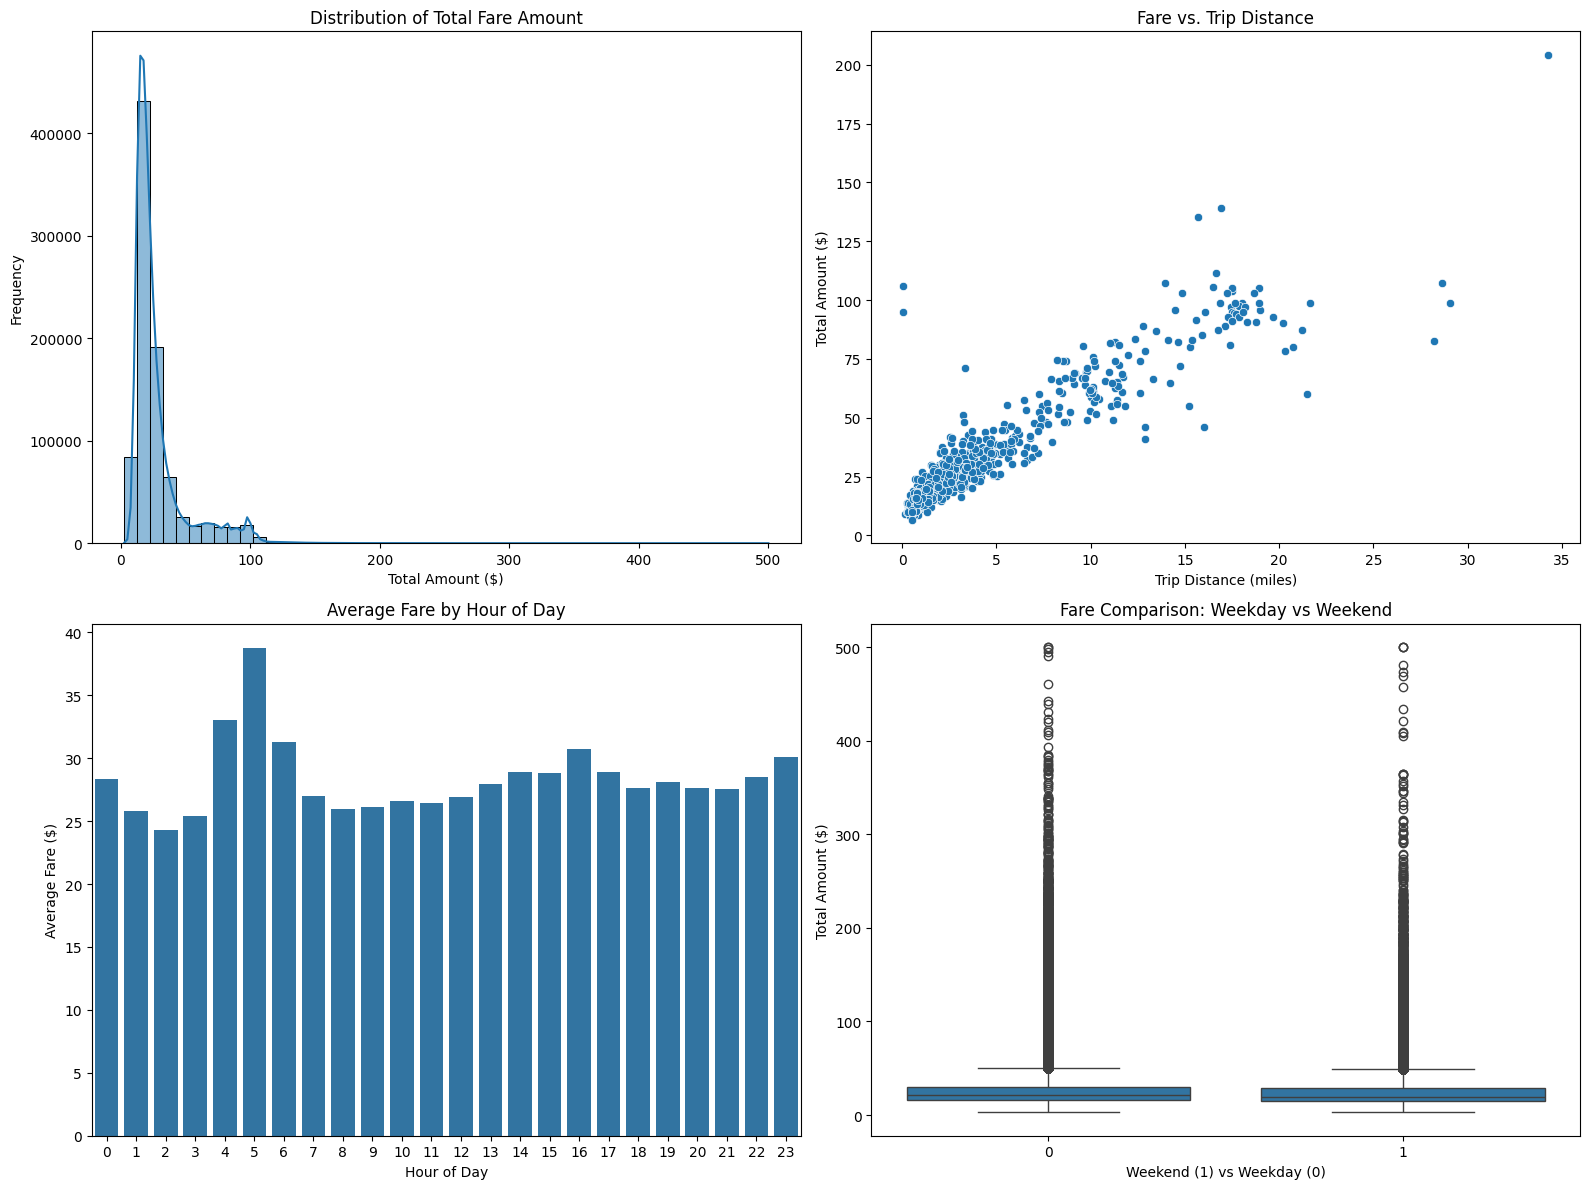


Step 4: Preparing features and splitting dataset...
Found weather columns: ['Temperature_C', 'Humidity_pct', 'Precipitation_mm', 'Wind_Speed_kmh']
Using these features for modeling: ['trip_distance', 'trip_duration', 'pickup_hour', 'is_rush_hour', 'is_weekend', 'is_airport_pickup', 'Temperature_C', 'Humidity_pct', 'Precipitation_mm', 'Wind_Speed_kmh']

Feature matrix shape: (893853, 10)
Training set: 715082 samples
Testing set: 178771 samples
Training set shape: (715082, 10)
Testing set shape: (178771, 10)
Features used: ['trip_distance', 'trip_duration', 'pickup_hour', 'is_rush_hour', 'is_weekend', 'is_airport_pickup', 'Temperature_C', 'Humidity_pct', 'Precipitation_mm', 'Wind_Speed_kmh']

Step 5: Training and evaluating models...

==== Linear Regression Model ====
Mean Squared Error: 56.48
Root Mean Squared Error: 7.52
Mean Absolute Error: 4.13
R² Score: 0.8821

Feature Importance:
             feature  coefficient
0      trip_distance    20.230321
3       is_rush_hour     0.589393


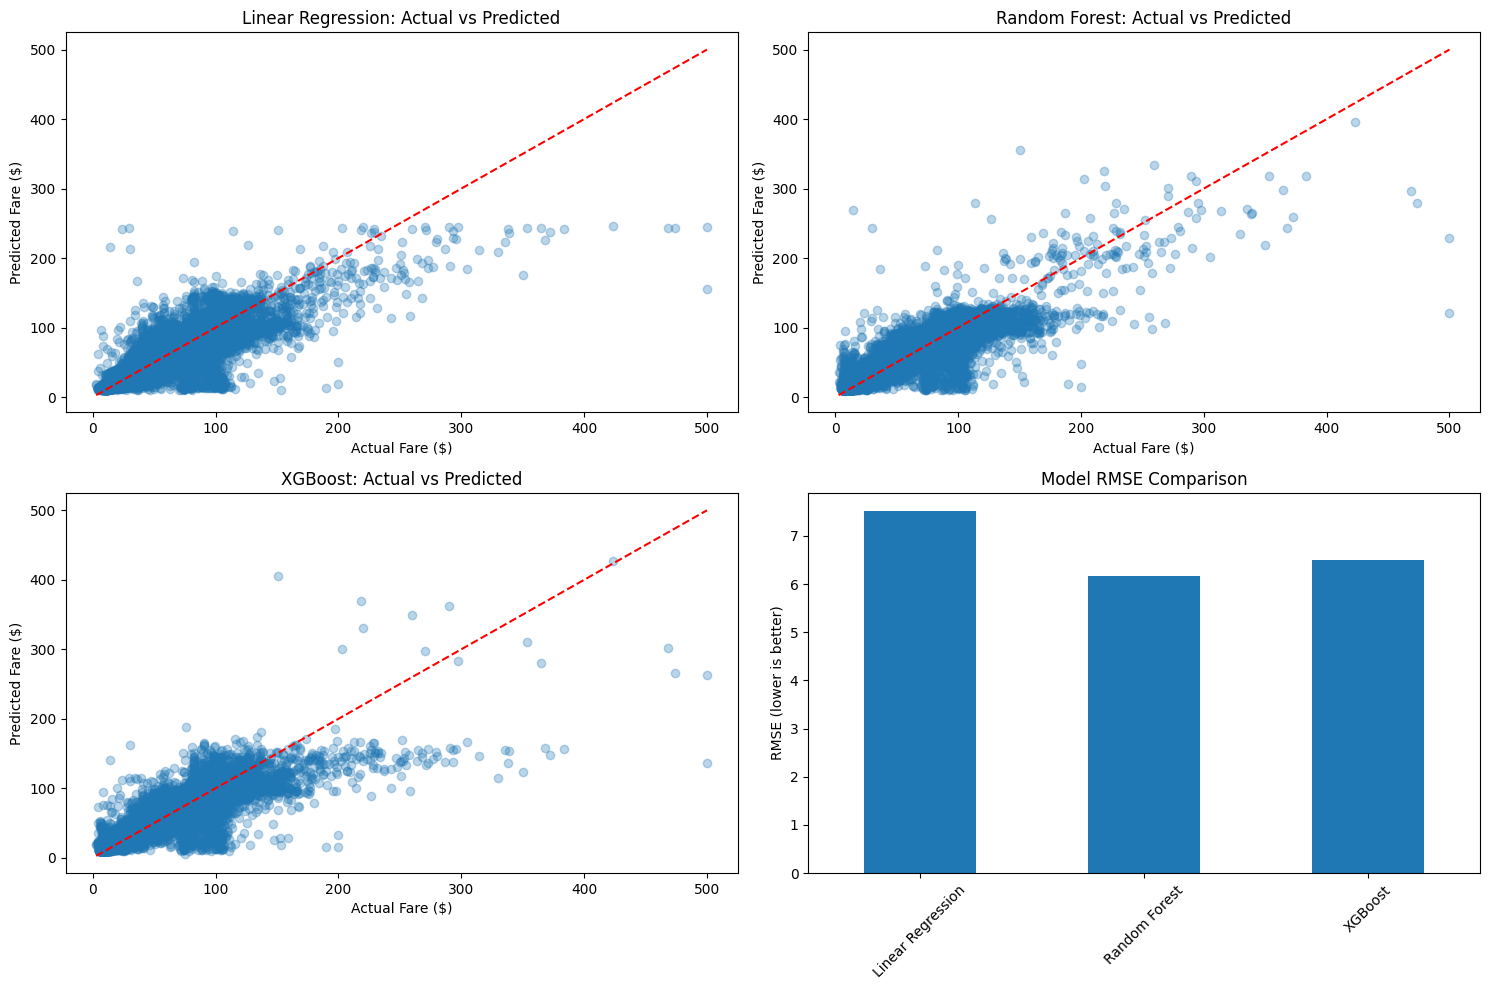


=== Model Comparison ===
                         MSE      RMSE       MAE        R²
Linear Regression  56.475673  7.515030  4.128511  0.882108
Random Forest      38.026822  6.166589  2.720759  0.920619
XGBoost            42.373405  6.509486  2.747212  0.911546

Best model based on RMSE: Random Forest
Models and scaler saved to models/ directory

Example Trip: {'trip_distance': 5.2, 'trip_duration': 900, 'pickup_hour': 18, 'is_rush_hour': 1, 'is_weekend': 0, 'is_airport_pickup': 0, 'Temperature_C': 14.94, 'Humidity_pct': 60.07, 'Precipitation_mm': 4.99, 'Wind_Speed_kmh': 15.08}
Predicted fare using Random Forest: $33.81

Pipeline completed successfully!


c:\Users\neera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [15]:
# Cell 12: Main Execution
def main():
    # Load local CSV data
    file_path = 'Final_file.csv'  # Update with your actual file path
    df = load_local_data(file_path)

    df.head()
    
    if df is not None:
        print("\nStep 1: Applying feature engineering...")
        df_processed = engineer_features(df)
        
        print("\nStep 2: Preprocessing data...")
        df_clean = preprocess_data(df_processed)
        
        print("\nStep 3: Visualizing data...")
        visualize_data(df_clean)
        
        print("\nStep 4: Preparing features and splitting dataset...")
        X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_names = prepare_features(df_clean)
        
        print(f"Training set shape: {X_train.shape}")
        print(f"Testing set shape: {X_test.shape}")
        print(f"Features used: {feature_names}")
        
        print("\nStep 5: Training and evaluating models...")
        # Training models
        lr_model, lr_predictions = train_linear_regression(X_train_scaled, y_train, X_test_scaled, y_test, feature_names)
        rf_model, rf_predictions = train_random_forest(X_train_scaled, y_train, X_test_scaled, y_test, feature_names)
        xgb_model, xgb_predictions = train_xgboost(X_train_scaled, y_train, X_test_scaled, y_test, feature_names)
        
        # Compare models
        model_predictions = {
            'Linear Regression': lr_predictions,
            'Random Forest': rf_predictions,
            'XGBoost': xgb_predictions
        }
        comparison_results = compare_models(y_test, model_predictions)
        
        # Save models
        models = {
            'Linear Regression': lr_model,
            'Random Forest': rf_model,
            'XGBoost': xgb_model
        }
        save_models(models, scaler)
        
        # Step 6: Demonstrate prediction with an example
        best_model_name = comparison_results['RMSE'].idxmin()
        best_model = models[best_model_name]
        
        # Example trip
        example_trip = {
            'trip_distance': 5.2,            # 5.2 miles
            'trip_duration': 900,            # 15 minutes (900 seconds)
            'pickup_hour': 18,               # 6 PM
            'is_rush_hour': 1,               # Rush hour
            'is_weekend': 0,                 # Weekday
            'is_airport_pickup': 0 ,          # Not an airport pickup
            'Temperature_C':14.94
            , 'Humidity_pct':60.07
            , 'Precipitation_mm':4.99
            , 'Wind_Speed_kmh':15.08
        }
        
        predicted_fare = predict_fare(
            best_model, scaler,
            example_trip['trip_distance'],
            example_trip['trip_duration'],
            example_trip['pickup_hour'],
            example_trip['is_rush_hour'],
            example_trip['is_weekend'],
            example_trip['is_airport_pickup'],
            example_trip['Temperature_C'],
            example_trip['Humidity_pct'],
            example_trip['Precipitation_mm'],
            example_trip['Wind_Speed_kmh'],
            
        )
        
        print(f"\nExample Trip: {example_trip}")
        print(f"Predicted fare using {best_model_name}: ${predicted_fare:.2f}")
        
        print("\nPipeline completed successfully!")

if __name__ == "__main__":
    main()

In [18]:
# Cell 13: Test Fare Prediction with Saved Models


def load_models():
    """Load saved models and scaler"""
    models = {
        'linear_regression': joblib.load('models/linear_regression_model.pkl'),
        'random_forest': joblib.load('models/random_forest_model.pkl'),
        'xgboost': joblib.load('models/xgboost_model.pkl')
    }
    scaler = joblib.load('models/feature_scaler.pkl')
    return models, scaler

def test_fare_prediction():
    """Test fare prediction using loaded models"""
    # Load models and scaler
    models, scaler = load_models()
    
    # Define example trip parameters
    example_trip = {
            'trip_distance': 5.2,            # 5.2 miles
            'trip_duration': 900,            # 15 minutes (900 seconds)
            'pickup_hour': 18,               # 6 PM
            'is_rush_hour': 1,               # Rush hour
            'is_weekend': 1,                 # Weekday
            'is_airport_pickup': 1 ,          # Not an airport pickup
            'Temperature_C':14.94
            , 'Humidity_pct':60.07
            , 'Precipitation_mm':4.99
            , 'Wind_Speed_kmh':15.08
        }
    
    print("Testing fare prediction with example trip:")
    print(example_trip)
    
    # Test each model
    for model_name, model in models.items():
        predicted_fare = predict_fare(
            model, scaler,
            example_trip['trip_distance'],
            example_trip['trip_duration'],
            example_trip['pickup_hour'],
            example_trip['is_rush_hour'],
            example_trip['is_weekend'],
            example_trip['is_airport_pickup'],
            example_trip['Temperature_C'],
            example_trip['Humidity_pct'],
            example_trip['Precipitation_mm'],
            example_trip['Wind_Speed_kmh']
        )
        
        print(f"\n{model_name.capitalize()} Model Prediction: ${predicted_fare:.2f}")

# Run the test
test_fare_prediction()

Testing fare prediction with example trip:
{'trip_distance': 5.2, 'trip_duration': 900, 'pickup_hour': 18, 'is_rush_hour': 1, 'is_weekend': 1, 'is_airport_pickup': 1, 'Temperature_C': 14.94, 'Humidity_pct': 60.07, 'Precipitation_mm': 4.99, 'Wind_Speed_kmh': 15.08}

Linear_regression Model Prediction: $38.16

Random_forest Model Prediction: $31.85

Xgboost Model Prediction: $32.67


c:\Users\neera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\neera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\neera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
